In [1]:
# setting working directory

#importing all libraries for modelling
import random
import os
os.chdir("D:\Anamika\F\Downloads")
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from sklearn.metrics import roc_curve ,auc,recall_score,precision_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from numpy import sqrt ,argmax
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline
rcParams['figure.figsize']= [10,10]

#set seed to have consistent values for all iterations
random.seed(10)

In [2]:
#loading the dataset
df = pd.read_csv(r"D:\Anamika\F\Semester 7\MDD\parkinsons.csv")
print(df)

               name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0    phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1    phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2    phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3    phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4    phon_R01_S01_5      116.014       141.781       110.655         0.01284   
5    phon_R01_S01_6      120.552       131.162       113.787         0.00968   
6    phon_R01_S02_1      120.267       137.244       114.820         0.00333   
7    phon_R01_S02_2      107.332       113.840       104.315         0.00290   
8    phon_R01_S02_3       95.730       132.068        91.754         0.00551   
9    phon_R01_S02_4       95.056       120.103        91.226         0.00532   
10   phon_R01_S02_5       88.333       112.240        84.072         0.00505   
11   phon_R01_S02_6       91.904       1

In [3]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [4]:
#checking for correalation among the variables. Removing the variables with correlation > 0.7
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),1,0.400985,0.596546,-0.118003,-0.382027,-0.0761938,-0.112165,-0.0762127,-0.0983737,-0.0737425,-0.0947171,-0.0706818,-0.0777738,-0.0947316,-0.0219808,0.0591444,-0.383535,-0.383894,-0.446013,-0.413738,-0.24945,0.17798,-0.372356
MDVP:Fhi(Hz),0.400985,1,0.0849513,0.102086,-0.0291983,0.0971766,0.0911262,0.0971499,0.00228123,0.0434652,-0.00374325,-0.00999678,0.00493698,-0.00373289,0.163766,-0.0248931,-0.166136,-0.112404,-0.343097,-0.0766578,-0.00295361,0.176323,-0.069543
MDVP:Flo(Hz),0.596546,0.0849513,1,-0.139919,-0.277815,-0.100519,-0.0958284,-0.100488,-0.144543,-0.119089,-0.150747,-0.101095,-0.107293,-0.150737,-0.10867,0.210851,-0.3802,-0.400143,-0.0504063,-0.394857,-0.243829,-0.100629,-0.340071
MDVP:Jitter(%),-0.118003,0.102086,-0.139919,1,0.935714,0.990276,0.974256,0.990276,0.769063,0.804289,0.746625,0.725561,0.758255,0.746635,0.906959,-0.728165,0.27822,0.360673,0.0985724,0.693577,0.385123,0.433434,0.721543
MDVP:Jitter(Abs),-0.382027,-0.0291983,-0.277815,0.935714,1,0.922911,0.897778,0.922913,0.703322,0.716601,0.697153,0.648961,0.648793,0.69717,0.834972,-0.65681,0.338653,0.441839,0.175036,0.735779,0.388543,0.310694,0.748162
MDVP:RAP,-0.0761938,0.0971766,-0.100519,0.990276,0.922911,1,0.957317,1,0.759581,0.790652,0.744912,0.709927,0.737455,0.744919,0.919521,-0.721543,0.266668,0.34214,0.064083,0.648328,0.324407,0.426605,0.670999
MDVP:PPQ,-0.112165,0.0911262,-0.0958284,0.974256,0.897778,0.957317,1,0.957319,0.797826,0.839239,0.76358,0.78678,0.804139,0.763592,0.844604,-0.73151,0.288698,0.333274,0.196301,0.716489,0.407605,0.412524,0.769647
Jitter:DDP,-0.0762127,0.0971499,-0.100488,0.990276,0.922913,1,0.957319,1,0.759555,0.790621,0.744894,0.709907,0.737439,0.744901,0.919548,-0.721494,0.266646,0.342079,0.0640264,0.648328,0.324377,0.426556,0.671005
MDVP:Shimmer,-0.0983737,0.00228123,-0.144543,0.769063,0.703322,0.759581,0.797826,0.759555,1,0.987258,0.987625,0.982835,0.950083,0.987626,0.722194,-0.835271,0.36743,0.447424,0.159954,0.654734,0.452025,0.507088,0.693771
MDVP:Shimmer(dB),-0.0737425,0.0434652,-0.119089,0.804289,0.716601,0.790652,0.839239,0.790621,0.987258,1,0.963198,0.973751,0.960977,0.963202,0.744477,-0.827805,0.350697,0.410684,0.165157,0.652547,0.454314,0.512233,0.695058


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:APQ            195 non-null float64
Shimmer:DDA         195 non-null float64
NHR                 195 non-null float64
HNR                 195 non-null float64
status              195 non-null int64
RPDE                195 non-null float64
DFA                 195 non-null float64
spread1             195 non-null float64
spread2             195 non-null floa

In [6]:
# csv version of correlation
df.corr(method ='pearson') 
df.to_csv('corr.csv')


In [7]:
# final variables for modelling after removing correlation
df_1 =df[['MDVP:Fhi(Hz)','MDVP:Flo(Hz)','MDVP:Jitter(%)','NHR','DFA','spread1','spread2','D2','PPE','status']]
df_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 10 columns):
MDVP:Fhi(Hz)      195 non-null float64
MDVP:Flo(Hz)      195 non-null float64
MDVP:Jitter(%)    195 non-null float64
NHR               195 non-null float64
DFA               195 non-null float64
spread1           195 non-null float64
spread2           195 non-null float64
D2                195 non-null float64
PPE               195 non-null float64
status            195 non-null int64
dtypes: float64(9), int64(1)
memory usage: 15.3 KB


In [8]:
# checking if there is a null value in the dataset
df_1.isnull().sum()

MDVP:Fhi(Hz)      0
MDVP:Flo(Hz)      0
MDVP:Jitter(%)    0
NHR               0
DFA               0
spread1           0
spread2           0
D2                0
PPE               0
status            0
dtype: int64

In [9]:
# print no of 0s and 1s in the dependant variable
print(df_1[df_1.status==0])
print(df_1[df_1.status==1])

# to check the unique values in a df
#print(df_1['status'].unique())

     MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)      NHR       DFA   spread1  \
30        206.896       192.055         0.00289  0.00339  0.741367 -7.348300   
31        209.512       192.091         0.00241  0.00167  0.742055 -7.682587   
32        215.203       193.104         0.00212  0.00119  0.738703 -7.067931   
33        211.604       197.079         0.00180  0.00072  0.742133 -7.695734   
34        211.526       196.160         0.00178  0.00065  0.741899 -7.964984   
35        210.565       195.708         0.00198  0.00135  0.742737 -7.777685   
42        247.326       225.227         0.00298  0.00740  0.654172 -7.310550   
43        248.834       232.483         0.00281  0.00675  0.634267 -6.793547   
44        250.912       232.435         0.00210  0.00454  0.635285 -7.057869   
45        255.034       227.911         0.00225  0.00476  0.638928 -6.995820   
46        262.090       231.848         0.00235  0.00476  0.631653 -7.156076   
47        261.487       182.786         

In [10]:
#splitting training and testing data
# stratify = y will maintain the ratio of 0s and 1s as population
y= df_1.status
x=df_1.drop(['status'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size =0.3,stratify=y)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(136, 9)
(136,)
(59, 9)
(59,)


[20:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\vatsa\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


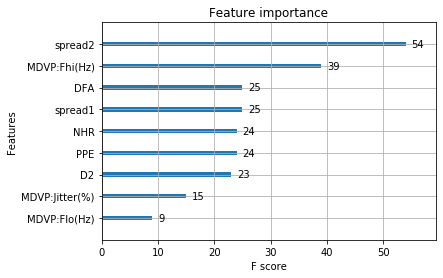

In [11]:
# building the xgboost model with training data and testing it on testing data
from xgboost import XGBClassifier
model = XGBClassifier()
import xgboost as xgb
model.fit(x_train, y_train)
pred1 =model.predict (x_test)
# Model based feature importance
plt.show()
xgb.plot_importance(model)


Best threshold=0.521453 ,G-Mean =0.955


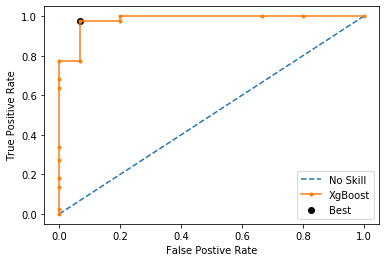

In [12]:
# Plotting the Auc curve and best threshold
yhat = model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds =roc_curve(y_test,yhat)
gmeans =sqrt(tpr* (1-fpr))
ix=argmax(gmeans)
print('Best threshold=%f ,G-Mean =%.3f' % (thresholds[ix],gmeans[ix]))
pyplot.plot([0,1],[0,1],linestyle ='--',label ='No Skill')
pyplot.plot(fpr,tpr,marker='.',label='XgBoost')
pyplot.scatter(fpr[ix],tpr[ix],marker='o',color='black',label='Best')
pyplot.xlabel('False Postive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [13]:
# based on confusion matrix, getting the accuracy, specificity, sensitivity 
#default threshold is 0.5
from sklearn.metrics import confusion_matrix
cm1 =confusion_matrix(y_test,pred1)
print(cm1)
total =sum(sum(cm1))

accuracy = (cm1[0,0]+cm1[1,1])/total
print('Accuracy :',accuracy)

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('specificity :',specificity)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('sensitivity :',sensitivity)

[[14  1]
 [ 1 43]]
Accuracy : 0.9661016949152542
specificity : 0.9333333333333333
sensitivity : 0.9772727272727273


In [14]:
#XGBoost hyper-parameter tuning
#def hyperParameterTuning(X_train, y_train):
 #   param_tuning = {
  #      'learning_rate': [0.01, 0.1],
   #     'max_depth': [3, 5, 7, 10],
    #    'min_child_weight': [1, 3, 5],
     #   'subsample': [0.5, 0.7],
      #  'colsample_bytree': [0.5, 0.7],
       # 'n_estimators' : [100, 200, 500],
        #'objective': ['reg:squarederror']
    #}

    #xgb_model = XGBClassifier()
    #scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
    #kfold = KFold(n_splits=10, random_state=42)

    #gsearch = GridSearchCV(estimator = xgb_model,
     #                      param_grid = param_tuning, 
         #                  scoring =scoring,     
          #                 cv = kfold,
           #                refit='AUC',
            #               n_jobs = -1,
             #              verbose = 1)

 #   gsearch.fit(x_train,y_train)

   # return gsearch.best_params_
#hyperParameterTuning(x_train, y_train)


In [15]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear',probability=True) 
#linear
#poly, degree =3
#rbf
#linear is performing better, but  the specificity is very low. so not choosing this algorithmmmmodel
model=svclassifier.fit(x_train, y_train)

In [16]:
y_pred = svclassifier.predict(x_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[10  5]
 [ 3 41]]
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.89      0.93      0.91        44

    accuracy                           0.86        59
   macro avg       0.83      0.80      0.81        59
weighted avg       0.86      0.86      0.86        59



Best threshold=0.719299 ,G-Mean =0.862


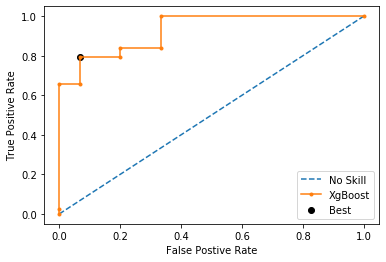

In [18]:
# Plotting the Auc curve and best threshold
yhat = model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds =roc_curve(y_test,yhat)
gmeans =sqrt(tpr* (1-fpr))
ix=argmax(gmeans)
print('Best threshold=%f ,G-Mean =%.3f' % (thresholds[ix],gmeans[ix]))
pyplot.plot([0,1],[0,1],linestyle ='--',label ='No Skill')
pyplot.plot(fpr,tpr,marker='.',label='XgBoost')
pyplot.scatter(fpr[ix],tpr[ix],marker='o',color='black',label='Best')
pyplot.xlabel('False Postive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [19]:
# based on confusion matrix, getting the accuracy, specificity, sensitivity 
#default threshold is 0.5
from sklearn.metrics import confusion_matrix
cm1 =confusion_matrix(y_test,y_pred)
total =sum(sum(cm1))

accuracy = (cm1[0,0]+cm1[1,1])/total
print('Accuracy :',accuracy)

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('specificity :',specificity)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('sensitivity :',sensitivity)

Accuracy : 0.864406779661017
specificity : 0.6666666666666666
sensitivity : 0.9318181818181818


In [20]:
from sklearn.ensemble import RandomForestClassifier
model_2=RandomForestClassifier(n_estimators=100)
model_2.fit(x_train,y_train)
pred_2=model_2.predict(x_test)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,pred_2))
print(classification_report(y_test,pred_2))

[[13  2]
 [ 2 42]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.95      0.95      0.95        44

    accuracy                           0.93        59
   macro avg       0.91      0.91      0.91        59
weighted avg       0.93      0.93      0.93        59



Best threshold=0.510000 ,G-Mean =0.910


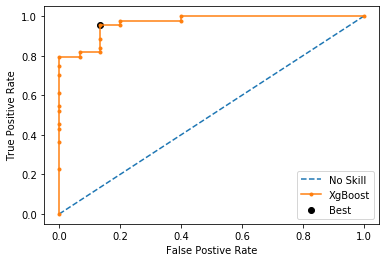

In [22]:
# Plotting the Auc curve and best threshold
yhat = model_2.predict_proba(x_test)[:,1]
fpr,tpr,thresholds =roc_curve(y_test,yhat)
gmeans =sqrt(tpr* (1-fpr))
ix=argmax(gmeans)
print('Best threshold=%f ,G-Mean =%.3f' % (thresholds[ix],gmeans[ix]))
pyplot.plot([0,1],[0,1],linestyle ='--',label ='No Skill')
pyplot.plot(fpr,tpr,marker='.',label='XgBoost')
pyplot.scatter(fpr[ix],tpr[ix],marker='o',color='black',label='Best')
pyplot.xlabel('False Postive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [23]:
# based on confusion matrix, getting the accuracy, specificity, sensitivity 
#default threshold is 0.5
from sklearn.metrics import confusion_matrix
cm1 =confusion_matrix(y_test,pred_2)
total =sum(sum(cm1))

accuracy = (cm1[0,0]+cm1[1,1])/total
print('Accuracy :',accuracy)

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('specificity :',specificity)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('sensitivity :',sensitivity)

Accuracy : 0.9322033898305084
specificity : 0.8666666666666667
sensitivity : 0.9545454545454546


In [24]:
# Method 1 - Voting
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('xg', model), ('rf', model_2)], voting='hard')
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.9152542372881356